In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import random

%matplotlib inline

In [2]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

In [4]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        """
        #dkl = - torch.log(self.data_rho/rho) * rho - torch.log((1-self.data_rho)/(1-rho)) * (1-rho)
        dkl = min(- torch.log(self.data_rho) * rho - torch.log(1-self.data_rho) * (1-rho))
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [5]:
models = {'16': Net(16), '32': Net(32), '64': Net(64)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [6]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        dataX = (data + torch.randn(data.size())).clamp(0,1)
        for model in models.values():
            model.optim.zero_grad()
            output = model(dataX)
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [7]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'rho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    rho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            dataX = (data + torch.randn(data.size())).clamp(0,1)
            output = {k: m(dataX) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
                rho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        rho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], rho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], rho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [8]:
for epoch in range(1, 41):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 1.124010 32: 1.133765 64: 1.139552
Train Epoch: 1 [10000/50000 (20%)]	Losses 16: 0.862036 32: 0.786290 64: 0.695773
Train Epoch: 1 [20000/50000 (40%)]	Losses 16: 0.869264 32: 0.764283 64: 0.738323
Train Epoch: 1 [30000/50000 (60%)]	Losses 16: 0.765623 32: 0.720624 64: 0.708641
Train Epoch: 1 [40000/50000 (80%)]	Losses 16: 0.739219 32: 0.719160 64: 0.699988
Train Epoch: 1 [50000/50000 (100%)]	Losses 16: 0.728015 32: 0.712065 64: 0.689815
Test set:
16: loss: 0.7240	rho_loss: 0.0002
32: loss: 0.7075	rho_loss: 0.0001
64: loss: 0.6799	rho_loss: 0.0001

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.717713 32: 0.704621 64: 0.680093
Train Epoch: 2 [10000/50000 (20%)]	Losses 16: 0.682356 32: 0.667217 64: 0.633867
Train Epoch: 2 [20000/50000 (40%)]	Losses 16: 0.707598 32: 0.687385 64: 0.646403
Train Epoch: 2 [30000/50000 (60%)]	Losses 16: 0.706482 32: 0.673487 64: 0.616451
Train Epoch: 2 [40000/50000 (80%)]	Losses 16: 0.722749 32: 0.683581 64: 0.630371
Train

Test set:
16: loss: 0.5368	rho_loss: 0.0002
32: loss: 0.4894	rho_loss: 0.0001
64: loss: 0.4514	rho_loss: 0.0001

Train Epoch: 15 [0/50000 (0%)]	Losses 16: 0.563300 32: 0.512654 64: 0.471196
Train Epoch: 15 [10000/50000 (20%)]	Losses 16: 0.541935 32: 0.494602 64: 0.457203
Train Epoch: 15 [20000/50000 (40%)]	Losses 16: 0.550958 32: 0.500462 64: 0.460746
Train Epoch: 15 [30000/50000 (60%)]	Losses 16: 0.546589 32: 0.494915 64: 0.453895
Train Epoch: 15 [40000/50000 (80%)]	Losses 16: 0.568692 32: 0.520780 64: 0.477298
Train Epoch: 15 [50000/50000 (100%)]	Losses 16: 0.542852 32: 0.497146 64: 0.454187
Test set:
16: loss: 0.5326	rho_loss: 0.0002
32: loss: 0.4856	rho_loss: 0.0001
64: loss: 0.4486	rho_loss: 0.0001

Train Epoch: 16 [0/50000 (0%)]	Losses 16: 0.526661 32: 0.479293 64: 0.443649
Train Epoch: 16 [10000/50000 (20%)]	Losses 16: 0.534553 32: 0.491012 64: 0.455429
Train Epoch: 16 [20000/50000 (40%)]	Losses 16: 0.548753 32: 0.502243 64: 0.465537
Train Epoch: 16 [30000/50000 (60%)]	Losses 16

Train Epoch: 28 [40000/50000 (80%)]	Losses 16: 0.473756 32: 0.428129 64: 0.399129
Train Epoch: 28 [50000/50000 (100%)]	Losses 16: 0.478949 32: 0.435429 64: 0.407055
Test set:
16: loss: 0.5048	rho_loss: 0.0002
32: loss: 0.4589	rho_loss: 0.0001
64: loss: 0.4288	rho_loss: 0.0001

Train Epoch: 29 [0/50000 (0%)]	Losses 16: 0.491337 32: 0.445353 64: 0.417995
Train Epoch: 29 [10000/50000 (20%)]	Losses 16: 0.498699 32: 0.454401 64: 0.419438
Train Epoch: 29 [20000/50000 (40%)]	Losses 16: 0.548081 32: 0.502395 64: 0.472343
Train Epoch: 29 [30000/50000 (60%)]	Losses 16: 0.502105 32: 0.454898 64: 0.421552
Train Epoch: 29 [40000/50000 (80%)]	Losses 16: 0.475831 32: 0.434618 64: 0.406829
Train Epoch: 29 [50000/50000 (100%)]	Losses 16: 0.508167 32: 0.461676 64: 0.429290
Test set:
16: loss: 0.5034	rho_loss: 0.0002
32: loss: 0.4579	rho_loss: 0.0001
64: loss: 0.4279	rho_loss: 0.0001

Train Epoch: 30 [0/50000 (0%)]	Losses 16: 0.525589 32: 0.479649 64: 0.446664
Train Epoch: 30 [10000/50000 (20%)]	Losses 1

In [9]:
data, _ = next(iter(test_loader))
output = models['64'](data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = models['64'].decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = models['64'].E(data.view(-1, 28*28))
    print((encoded > 0.5).sum(1))
    encoded[encoded < 0.5] = 0.
    decoded_f = models['64'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([44, 41, 42, 44, 39, 43, 40, 44, 38, 44, 45, 42, 47, 45, 39, 37, 41, 40,
        41, 44, 42, 41, 39, 46, 42, 43, 39, 43, 45, 38, 47, 43, 42, 39, 41, 42,
        38, 41, 43, 42, 34, 42, 41, 41, 40, 42, 43, 45, 43, 38])


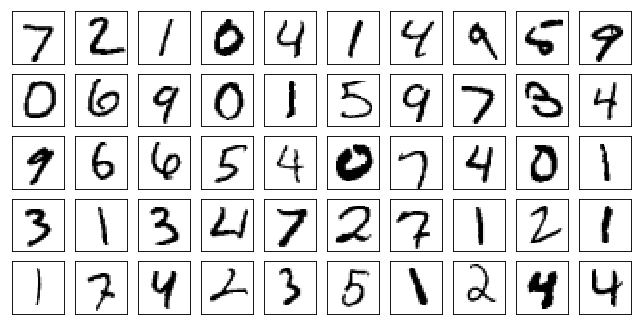

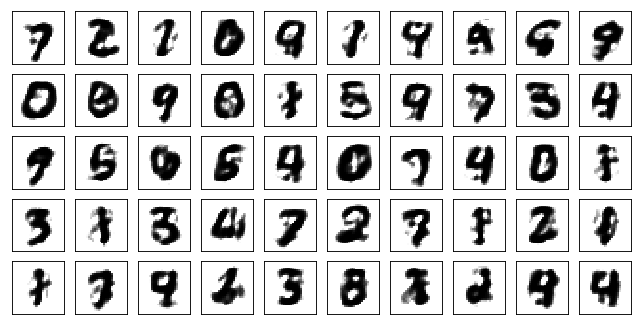

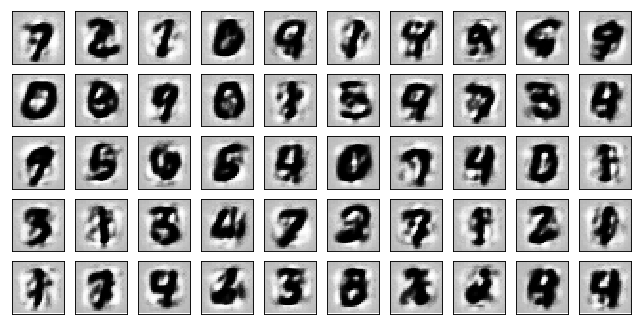

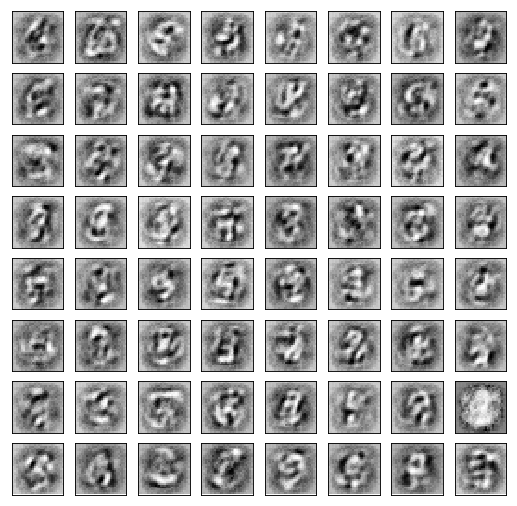

In [10]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8))